# Chapter05 순환 신경망(RNN)

지금까지 살펴본 신경망은 $\textbf{피드 포워드}^{\text{feed forward, 앞먹임}}$ 유형의 신경망이다.

피드 포워드란 흐름이 단방향인 신경망으로, 입력 신호가 한 방향으로만 전달되는 신경망을 말한다.

피드 포워드 신경망은 구성이 단순하여 구조 이해가 쉽고 많은 문제에 응용가능하나,

시계열 데이터를 잘 다루지 못한다는 단점이 있다.

더 정확히는, 단순한 피드 포워드 신경망에서는 시계열 데이터의 성질(패턴)을 충분히 할 수 없다.

그래서 $\textbf{순환 신경망}^{\text{Recurrent Neural Network}} \textbf{(RNN)}$ 이 등장하게 된다.

## 5.1 확률과 언어 모델

앞 장의 word2vec을 복습하면서 자연어에 관한 현상을 '확률'을 통해 기술하고, 마지막에는 언어를 확률로 다루는 '언어 모델'에 대해 설명한다.

### 5.1.1 word2vec을 확률 관점에서 바라보다

word2vec의 CBOW 모델부터 복습해본다. 이때 $w_1, w_2, \cdots, w_T$ 라는 단어열로 표현되는 말뭉치를 가정한다.

그리고 $t$ 번째 단어를 '타깃'으로, 전후 단어($t-1$ 번째, $t+1$ 번째)를 '맥락'으로 취급한다.

이때 CBOW 모델은 [그림 5-1]과 같이 맥락 $w_{t-1}$ 과 $w_{t+1}$ 을 추측하는 일을 수행한다.

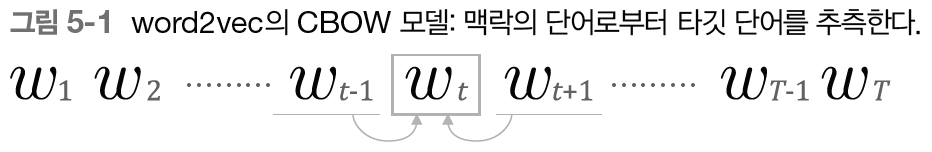

In [1]:
import os
from PIL import Image

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
img_path = os.path.join(parent_dir, 'images')

Image.open(os.path.join(img_path, 'fig 5-1.png'))

이때 $w_{t-1}$ 과 $w_{t+1}$ 이 주어졌을 때 타깃이 $w_t$가 될 확률을 수식으로 나타내면 다음과 같다.

\begin{equation*}
    P(w_t | w_{t-1}, w_{t+1})
    \tag{5.1}
\end{equation*}

CBOW 모델은 식 (5.1)의 사후 확률을 모델링한다. 이 사후 확률은 '$w_{t-1}$ 과 $w_{t+1}$ 이 주어졌을 때 $w_t$ 가 일어날 확률'을 뜻한다. 이것은 윈도우 크기가 1일 때의 CBOW 모델이다.

지금까지는 맥락을 항상 좌우 대칭으로 생각해왔는데, 이번에는 맥락을 왼쪽 윈도우에 한정해본다.

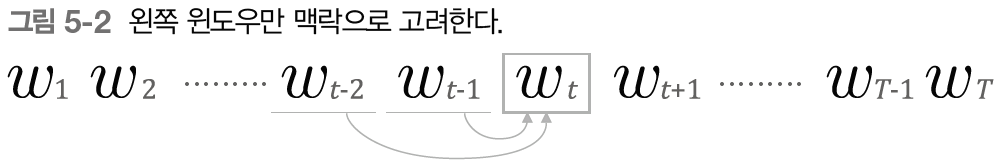

In [2]:
Image.open(os.path.join(img_path, 'fig 5-2.png'))

그러면 CBOW 모델이 출력할 확률은 다음 식과 같게 된다.

\begin{equation*}
    P(w_t | w_{t-1}, w_{t-2})
    \tag{5.2}
\end{equation*}

이 경우 CBOW 모델이 다루는 손실 함수는 교차 엔트로피 오차에 의해 다음과 같이 유도된다.

\begin{equation*}
    L = -\log P(w_t | w_{t-1}, w_{t-2})
    \tag{5.3}
\end{equation*}

CBOW 모델의 학습으로 수행하는 일은 식 (5.3)의 손실 함수(말뭉치 전체의 손실 함수의 총합)를 최소화하는 가중치 매개변수를 찾는 것이다.

이러한 가중치 매개변수가 발견되면 CBOW 모델은 맥락으로부터 타깃을 더 정확하게 추측할 수 있게 된다.

이처럼 CBOW 모델을 학습시키는 본래 목적은 맥락으로부터 타깃을 정확하게 추측하는 것이다.

이 목적을 위해 학습을 진행하면, 단어의 의미가 인코딩된 '단어의 분산 표현'을 얻을 수 있다.

그럼 자연스레 CBOW 모델의 본래 목적인 '맥락으로부터 타깃을 추측하는 것'을 좀 더 폭넓게 쓰고 싶은 욕심이 생기게 된다.

달리 말해 식 (5.2)의 확률을 실용적으로 쓰고 싶은 생각이 드는데, 여기서 '언어 모델'이 등장한다.

### 5.1.2 언어 모델

$\textbf{언어 모델}^{\text{Language Model}}$ 은 단어 나열에 확률을 부여한다.

특정한 단어의 시퀀스에 대해서, 그 시퀀스가 일어날 가능성을 확률로 평가한다(얼마나 자연스러운 단어 순서인지).

이 언어 모델은 다양하게 응용 가능하다.
- 기계 번역 : 외국어 문장 자동 한국어 번역
- 음성 인식 : 사람 음성으로부터 몇 개의 문장 후보 생성 $\rightarrow$ 언어 모델 $\rightarrow$ 자연스러운 순서로 문장 배열
- 문장 생성 : 단어 순서의 자연스러움에 대한 확률적 평가 가능 $\rightarrow$ 확률분포에 따라 다음으로 적합한 단어 샘플링

언어 모델 수식
- $w_1, \ldots, w_m$ : $m$ 개 단어로 된 문장
- $P(w_1, \ldots, w_m)$ : 단어가 $w_1, \ldots, w_m$ 이라는 순서로 출현할 확률 (결합확률, 동시확률)

\begin{align*}
    P(w_1, \ldots, w_m) & = P(w_m | w_1, \ldots, w_{m-1}) P(w_{m-1} | w_1, \ldots, w_{m-2}) \\
    & \quad \cdots P(w_3 | w_1, w_2) P(w_2 | w_1) P(w_1) \\
    & = \prod_{t=1}^{m} P(w_t | w_1, \ldots w_{t-1})
    \tag{5.4}
\end{align*}

식 (5.4) 에서 알 수 있듯이 목적으로 하는 동시 확률 $P(w_1, \ldots, w_m)$ 은 사후확률의 총곱인 $\prod_{t=1}^{m} P(w_t | w_1, \ldots w_{t-1})$ 으로 대표될 수 있다. 

여기서 주목해야 할 점은 이 사후 확률은 타깃 단어보다 왼쪽에 있는 모든 단어를 맥락(조건)으로 했을 때의 확률이라는 것이다.

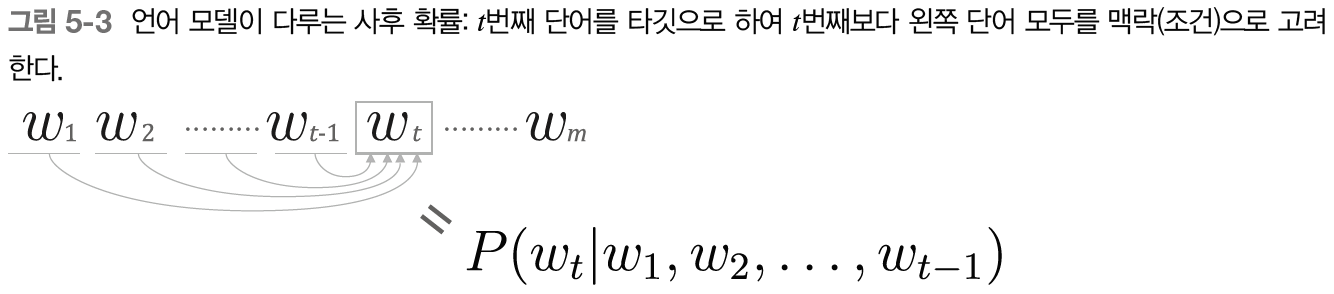

In [3]:
Image.open(os.path.join(img_path, 'fig 5-3.png'))

정리하면, 우리의 목표는 $P(w_t | w_1, \ldots, w_{t-1})$ 이라는 확률을 얻는 것이다.

이 확률에 대한 계산이 가능하게 되면 언어 모델의 동시 확률 $P(w_1, \ldots, w_m)$ 을 구할 수 있게 된다.

$\textbf{NOTE}$

$P(w_t | w_1, \ldots, w_{t-1})$ 을 나타내는 모델은 $\textbf{조건부 언어 모델}^{\text{Conditional Language Model}}$ 이라고 한다. 한편, $P(w_t | w_1, \ldots, w_{t-1})$ 을 나타내는 모델을 가리켜, 그것을 '언어 모델'이라 하는 경우도 많이 볼 수 있다.

### 5.1.3 CBOW 모델을 언어 모델로?

그러면 word2vec의 CBOW 모델을 (억지로) 언어 모델에 적용하려면 어떻게 하면 좋을까?

맥락의 크기를 특정 값으로 한정해서 근사적으로 나타내 볼 수 있다. 수식으로는 다음과 같다.

\begin{equation*}
    P(w_1, \ldots, w_m) = \prod_{t=1}^{m} P(w_t | w_1, \ldots, w_{t-1}) \approx \prod_{t=1}^{m} P(w_t | w_{t-1}, w_{t-2})
    \tag{5.5}
\end{equation*}

식 (5.5)는 맥락을 왼쪽 2개의 단어로 한정한 경우이다. 

그러면 CBOW 모델에 따라 (CBOW 모델의 사후 확률에 따라) 언어 모델의 동시확률을 근사적으로 나타낼 수 있게 된다.

$\textbf{NOTE}$

머신러닝이나 통계학에서는 $\textbf{마르코프 연쇄}^{\text{Markov Chain}}$ 또는 $\textbf{마르코프 모델}^{\text{Markov Model}}$ 이라는 말을 자주 듣는다. 마르코프 연쇄란 미래의 상태가 현재 상태에만 의존해 결정되는 것을 말한다. 또한 이 사상의 확률이 '그 직전' $N$ 개의 사건에만 의존할 때, 이를 '$N$ 층 마르코프 연쇄' 라고 한다. 식 (5.5)의 경우 직전 2개의 단어에만 의존해 다음 단어가 정해지는 모델을 고려하므로 '2층 마르코프 연쇄'라고 부를 수 있다.

식 (5.5) 에서는 맥락으로 2개의 단어를 이용하는 예를 나타냈으나, 맥락의 크기는 임의 길이로 설정 가능하다(5개, 10개 등).

그러나 임의 길이로 설정할 수 있다고 해도, 결국 특정 길이로 '고정'된다.

예를 들어 왼쪽 10개의 단어를 맥락으로 CBOW 모델을 만들 때, 그 맥락보다 더 왼쪽에 있는 단어의 정보는 무시된다.

예를 들면 다음 그림과 같다.

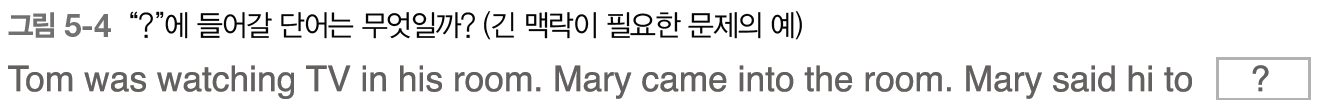

In [4]:
Image.open(os.path.join(img_path, 'fig 5-4.png'))

[그림 5-4]의 문제의 정답은 문맥(맥락)을 고려하면 'Tom'이 된다.

즉 언어 모델이 이 문제를 풀려면 예문의 "?"로부터 18번째 앞에 있는 "Tom"을 기억해야 한다.

CBOW 모델의 경우 고정된 맥락크기가 10인 경우 (혹은 18개 미만) 이 문제에 제대로 대답할 수 없다.

그럼 CBOW 모델의 맥락 크기를 늘리면 문제가 해결 될 것인가? 크기는 무한정 늘릴 순 있다.

그러나 CBOW 모델에서는 맥락 안의 단어 순서가 무시된다는 한계가 존재한다.

맥락의 단어 순서가 무시되는 문제의 구체적인 예를 보도록 한다.

예를 들어 맥락으로 2개의 단어를 다루는 경우, CBOW 모델에서는 다음 그림과 같이 이 2개의 단어 벡터의 '합'이 은닉층에 온다.

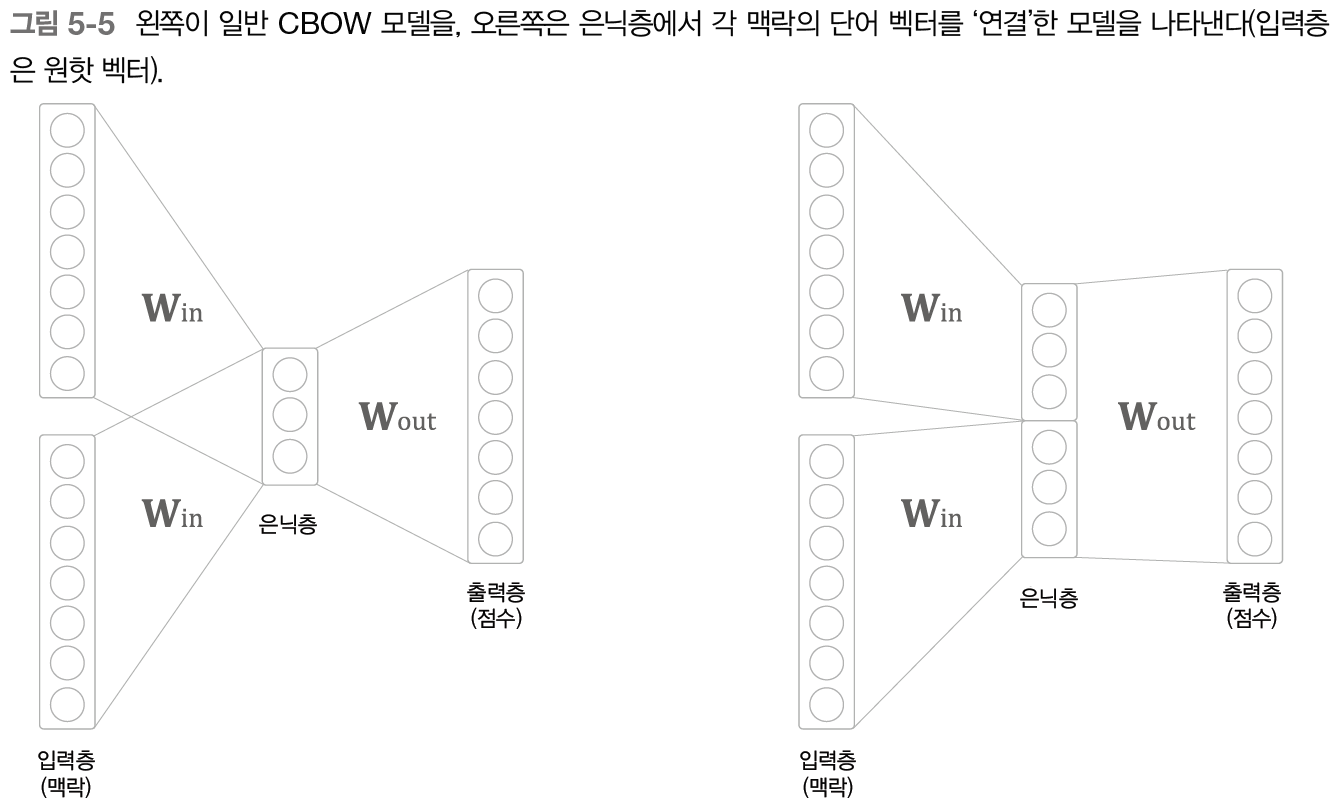

In [5]:
Image.open(os.path.join(img_path, 'fig 5-5.png'))

[그림 5-5]의 왼쪽 그림과 같이 CBOW 모델의 은닉층에서는 단어 벡터들이 더해지므로 맥락의 단어 순서는 무시된다. 예를 들어 (you, say)와 (say, you)라는 맥락은 동일한 맥락으로 취급된다.

이상적으로는 맥락의 단어 순서도 고려한 모델이 바람직할 것이다.

이를 위해 [그림 5-5]의 오른쪽 그림처럼 맥락의 단어 벡터를 은닉층에서 $\textbf{연결}^{\text{concatenate}}$ 하는 방식을 생각할 수 있다. 실제로 $\text{신경 확률론적 언어 모델}^{\text{Neural Probabilistic Language Model}}$ 에서 제안하는 모델은 이 방식을 채택한다. 

그러나 이러한 연결 방식은 맥락의 크기에 비례해서 가중치 매개변수도 늘어난다는 단점이 있다.

그렇다면 이 문제는 어떻게 해결해야 할 것인가? 여기서 등장하는 것이 순환 신경망, 즉 RNN이다.

RNN은 맥락이 아무리 길더라도 그 맥락의 정보를 기억하는 메커니즘을 갖춘다. 그래서 RNN을 사용하면 아무리 긴 시계열 데이터여도 대응가능하다.

$\textbf{WARNING}$

word2vec은 애초의 목적이 단어의 분산 표현을 얻기 위함을 잊지 말도록 한다.

## 5.2 RNN 이란

$\textbf{RNN}^{\text{Recurrent Neural Network}}$ 의 'Recurrent'는 라틴어에서 온 말로, '몇 번이나 반복해서 일어나는 일'을 뜻한다. 우리말로 '재발한다', '주기적으로 일어난다', '순환한다'등으로 번역된다. 그래서 RNN을 직역하면 '순환하는 신경망'이 되는 것이다. 이제부터 이 '순환한다'는 말의 의미를 이해해보도록 한다.